<a href="https://colab.research.google.com/github/stonewallmhk/QuantMindi/blob/main/SP500_Sector_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [39]:
import yfinance as yf
import pandas as pd
from tqdm import tqdm
import datetime
import os
import matplotlib.pyplot as plt

In [3]:
# prompt: increase output row length to extend to screen

pd.set_option('display.max_rows', None)
pd.set_option('display.width', 900)

In [11]:
tickers_names = {
    "XLC": "Communication Services",
    "XLY": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "XLE": "Energy",
    "XLF": "Financials",
    "XLV": "Health Care",
    "XLI": "Industrials",
    "XLB": "Materials",
    "XLRE": "Real Estate",
    "XLK": "Technology",
    "XLU": "Utilities",
}

# 1. Function to fetch data for a given ticker symbol and commodity name
def fetch_data(ticker_symbol, commodity_name):
    ticker = yf.Ticker(ticker_symbol)
    today = datetime.date.today().strftime('%Y-%m-%d')
    data = ticker.history(start="1900-01-01", end=today)
    data.reset_index(inplace=True)

    # Check if the 'Date' column is of datetime type
    if pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = data['Date'].dt.strftime('%Y-%m-%d')

    # Drop the unnecessary columns
    data.drop(columns=['Dividends', 'Stock Splits', 'Capital Gains'], inplace=True, errors='ignore')

    data['ticker'] = ticker_symbol
    data['sector'] = commodity_name

    # Convert other column names to lowercase
    data.columns = [col.lower() for col in data.columns]

    # Reorder columns to have 'ticker' and 'commodity' at the beginning
    data = data[['ticker', 'sector'] + [col for col in data.columns if col not in ['ticker', 'sector']]]

    return data


# 2. Loop over each symbol and append data to the master DataFrame
all_data = []
for symbol, name in tqdm(tickers_names.items(), desc="Fetching data"):  # tqdm progress bar!
    all_data.append(fetch_data(symbol, name))

# Concatenate all the individual datasets into one
master_data = pd.concat(all_data, ignore_index=True)

Fetching data: 100%|██████████| 11/11 [00:02<00:00,  5.16it/s]


In [12]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62174 entries, 0 to 62173
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  62174 non-null  object 
 1   sector  62174 non-null  object 
 2   date    62174 non-null  object 
 3   open    62174 non-null  float64
 4   high    62174 non-null  float64
 5   low     62174 non-null  float64
 6   close   62174 non-null  float64
 7   volume  62174 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 3.8+ MB


In [6]:
master_data.head()

,ticker,sector,date,open,high,low,close,volume
0,XLC,Communication Services,2018-06-19,46.914399,47.254222,46.801125,47.159824,16600
1,XLC,Communication Services,2018-06-20,47.622349,48.036743,47.622349,47.745064,190000
2,XLC,Communication Services,2018-06-21,47.924414,47.999928,47.386362,47.452438,428700
3,XLC,Communication Services,2018-06-22,47.754512,47.773391,47.376930,47.660118,181500
4,XLC,Communication Services,2018-06-25,47.414687,47.414687,46.267786,46.678406,2509600


In [7]:
# prompt: Get the min and max date for every ticker

# Group by ticker and get the min and max date
min_max_dates = master_data.groupby('ticker')['date'].agg(['min', 'max'])

print(min_max_dates)


               min         max
ticker                        
XLB     1998-12-22  2024-09-26
XLC     2018-06-19  2024-09-26
XLE     1998-12-22  2024-09-26
XLF     1998-12-22  2024-09-26
XLI     1998-12-22  2024-09-26
XLK     1998-12-22  2024-09-26
XLP     1998-12-22  2024-09-26
XLRE    2015-10-08  2024-09-26
XLU     1998-12-22  2024-09-26
XLV     1998-12-22  2024-09-26
XLY     1998-12-22  2024-09-26


**Perform Analysis of an investment of USD 100 every month from 01-Jan-1999 till date with returns compunded annually**

#Step 1: Prepare Your Data

First, load your data into a pandas DataFrame and preprocess it by converting date strings to datetime objects, and exclude the tickers XLC and XLRE.

In [8]:
# Convert 'date' to datetime
master_data['date'] = pd.to_datetime(master_data['date'])

# Filter out specific tickers
filtered_data = master_data[~master_data['ticker'].isin(['XLC', 'XLRE'])]

# Ensure data is sorted by date for each ticker
filtered_data.sort_values(by=['ticker', 'date'], inplace=True)

<ipython-input-8-8050a132e9cc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.sort_values(by=['ticker', 'date'], inplace=True)


#Step 2: Calculate Monthly Investment Returns

To simulate the investment, you’ll need to resample the data to a monthly frequency, calculate the returns, and simulate the compounding investment.

In [10]:
filtered_data = filtered_data.reset_index(drop=True)
filtered_data.head()

,ticker,sector,date,open,high,low,close,volume
0,XLB,Materials,1998-12-22,11.750298,11.776802,11.732628,11.776802,1900
1,XLB,Materials,1998-12-23,11.856324,11.953507,11.856324,11.900498,700
2,XLB,Materials,1998-12-24,12.041850,12.174373,11.988842,12.174373,1500
3,XLB,Materials,1998-12-28,12.156707,12.156707,12.050689,12.068358,2500
4,XLB,Materials,1998-12-29,12.289228,12.289228,12.289228,12.289228,100


In [13]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58338 entries, 0 to 58337
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ticker  58338 non-null  object        
 1   sector  58338 non-null  object        
 2   date    58338 non-null  datetime64[ns]
 3   open    58338 non-null  float64       
 4   high    58338 non-null  float64       
 5   low     58338 non-null  float64       
 6   close   58338 non-null  float64       
 7   volume  58338 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 3.6+ MB


In [14]:
# Set 'date' as the index if not already
filtered_data.set_index('date', inplace=True)

In [32]:
# prompt: group by ticker and resample to monthly using the last available price

monthly_data = filtered_data.groupby('ticker')['close'].resample('M').last()


In [33]:
#monthly_prices = monthly_prices.reset_index()
#monthly_prices.set_index('date', inplace=True)
monthly_data.head()

ticker  date      
XLB     1998-12-31    12.395246
        1999-01-31    11.935835
        1999-02-28    12.121369
        1999-03-31    12.339425
        1999-04-30    15.388814
Name: close, dtype: float64

In [35]:
# Calculate the number of shares bought each month
monthly_data = monthly_data.reset_index()
monthly_data['shares_bought'] = 100 / monthly_data['close']
monthly_data.set_index(['ticker','date'], inplace=True)
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2790 entries, ('XLB', Timestamp('1998-12-31 00:00:00')) to ('XLY', Timestamp('2024-09-30 00:00:00'))
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          2790 non-null   int64  
 1   close          2790 non-null   float64
 2   shares_bought  2790 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 84.6+ KB


In [36]:
# Calculate cumulative shares bought by each ticker
monthly_data['cumulative_shares'] = monthly_data.groupby('ticker')['shares_bought'].cumsum()
print(monthly_data.info())
print(monthly_data.head())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2790 entries, ('XLB', Timestamp('1998-12-31 00:00:00')) to ('XLY', Timestamp('2024-09-30 00:00:00'))
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              2790 non-null   int64  
 1   close              2790 non-null   float64
 2   shares_bought      2790 non-null   float64
 3   cumulative_shares  2790 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 106.4+ KB
None
                   index      close  shares_bought  cumulative_shares
ticker date                                                          
XLB    1998-12-31      0  12.395246       8.067609           8.067609
       1999-01-31      1  11.935835       8.378132          16.445741
       1999-02-28      2  12.121369       8.249893          24.695634
       1999-03-31      3  12.339425       8.104105          32.799740
       1999-04-30      4  15.388814       6.498227 

In [37]:
monthly_data['investment_value'] = monthly_data['cumulative_shares'] * monthly_data['close']
print(monthly_data.info())
print(monthly_data.head())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2790 entries, ('XLB', Timestamp('1998-12-31 00:00:00')) to ('XLY', Timestamp('2024-09-30 00:00:00'))
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              2790 non-null   int64  
 1   close              2790 non-null   float64
 2   shares_bought      2790 non-null   float64
 3   cumulative_shares  2790 non-null   float64
 4   investment_value   2790 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 128.2+ KB
None
                   index      close  shares_bought  cumulative_shares  investment_value
ticker date                                                                            
XLB    1998-12-31      0  12.395246       8.067609           8.067609        100.000000
       1999-01-31      1  11.935835       8.378132          16.445741        196.293654
       1999-02-28      2  12.121369       8.249893          24.695634  

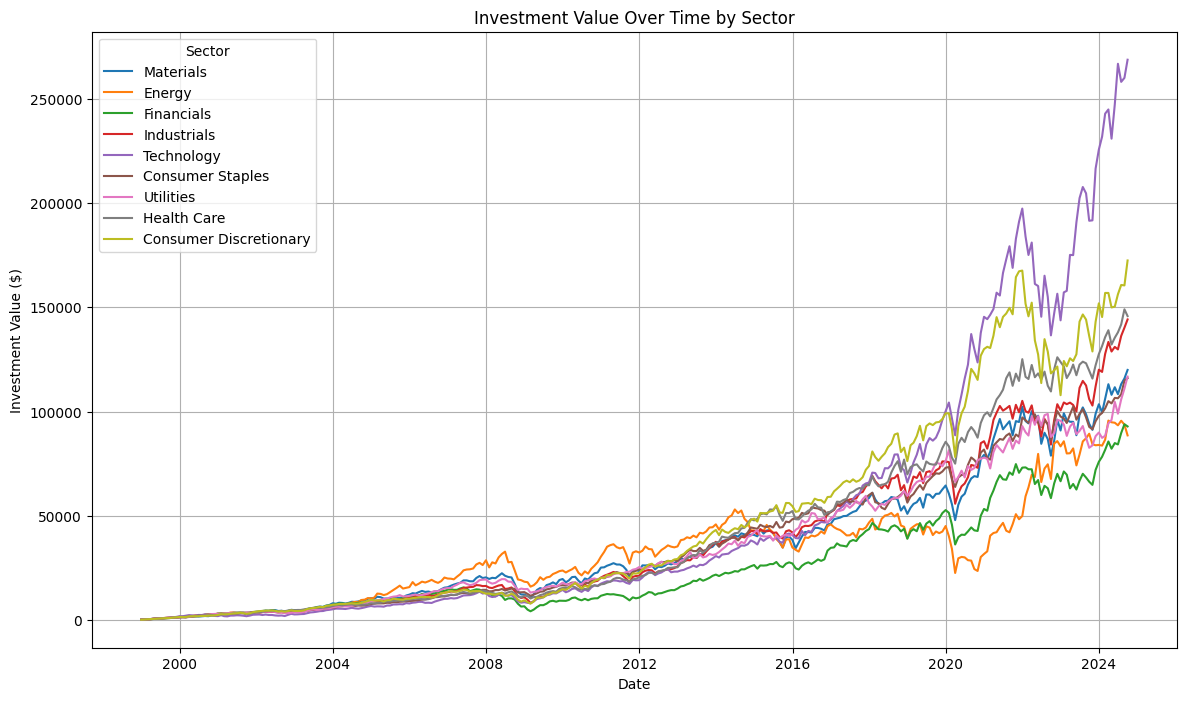

In [41]:
# Reset index for easier plotting
plot_data = monthly_data.reset_index()

# Pivot the data for easy plotting
pivot_data = plot_data.pivot(index='date', columns='ticker', values='investment_value')

# Plotting
plt.figure(figsize=(14, 8))

for column in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[column], label=tickers_names.get(column, "Unknown"))

plt.title('Investment Value Over Time by Sector')
plt.xlabel('Date')
plt.ylabel('Investment Value ($)')
plt.legend(title='Sector')
plt.grid(True)
plt.show()

In [43]:
# prompt: Get the last investment_value of each ticker

last_investment_value = monthly_data.groupby('ticker')['investment_value'].last()
print(last_investment_value)


ticker
XLB    119953.829665
XLE     88551.408855
XLF     92856.151966
XLI    144187.767121
XLK    268806.777349
XLP    116035.567306
XLU    116747.566734
XLV    145793.940021
XLY    172477.781892
Name: investment_value, dtype: float64


In [48]:
# prompt: count how many unique dates and multiply by 100 to get the total invested amount. From the earlier last_investment_value per each ticker calculate the net return percentage

# Count unique dates
unique_dates_count = monthly_data.reset_index()['date'].nunique()

# Total invested amount
total_invested_amount = unique_dates_count * 100

# Calculate net return percentage for each ticker
net_return_percentage = (last_investment_value / total_invested_amount) * 100

print(f"Total Invested Amount: ${total_invested_amount}")
print("\nNet Return Percentage by Ticker:")
print(net_return_percentage.sort_values(ascending=False))


Total Invested Amount: $31000

Net Return Percentage by Ticker:
ticker
XLK    867.118637
XLY    556.379942
XLV    470.303032
XLI    465.121829
XLB    386.947838
XLU    376.605054
XLP    374.308282
XLF    299.535974
XLE    285.649706
Name: investment_value, dtype: float64


In [50]:
# prompt: Total investment_value at end of every 5th year per ticker with year in column and ticker as index

# Group by ticker and year (rounded down to the nearest 5 years)
yearly_data = monthly_data.reset_index()
yearly_data['year'] = (yearly_data['date'].dt.year // 5) * 5  # Round down to nearest 5 years
yearly_data = yearly_data.groupby(['ticker', 'year'])['investment_value'].last().unstack()

print(yearly_data)


year           1995          2000          2005          2010           2015           2020
ticker                                                                                     
XLB     1458.058895  10429.053552  19639.284111  40790.176453   64499.914858  119953.829665
XLE     1367.130858  10290.726328  23717.710633  42946.085769   45059.720752   88551.408855
XLF     1275.113956   9249.910394   9193.114272  26340.398922   52711.190005   92856.151966
XLI     1420.353672   9067.893433  14779.698248  42668.623329   76001.894321  144187.767121
XLK     1775.819527   6683.929082  14414.415809  37409.803398  100217.663206  268806.777349
XLP     1195.602813   7627.223110  16623.474090  44051.158398   73028.469752  116035.567306
XLU     1268.091026   8838.609242  17875.452642  41967.599336   76228.479792  116747.566734
XLV     1440.585270   8008.809339  15307.651319  47762.421165   85477.488616  145793.940021
XLY     1447.639632   9601.691181  14752.525478  48549.260762   99117.499817  17